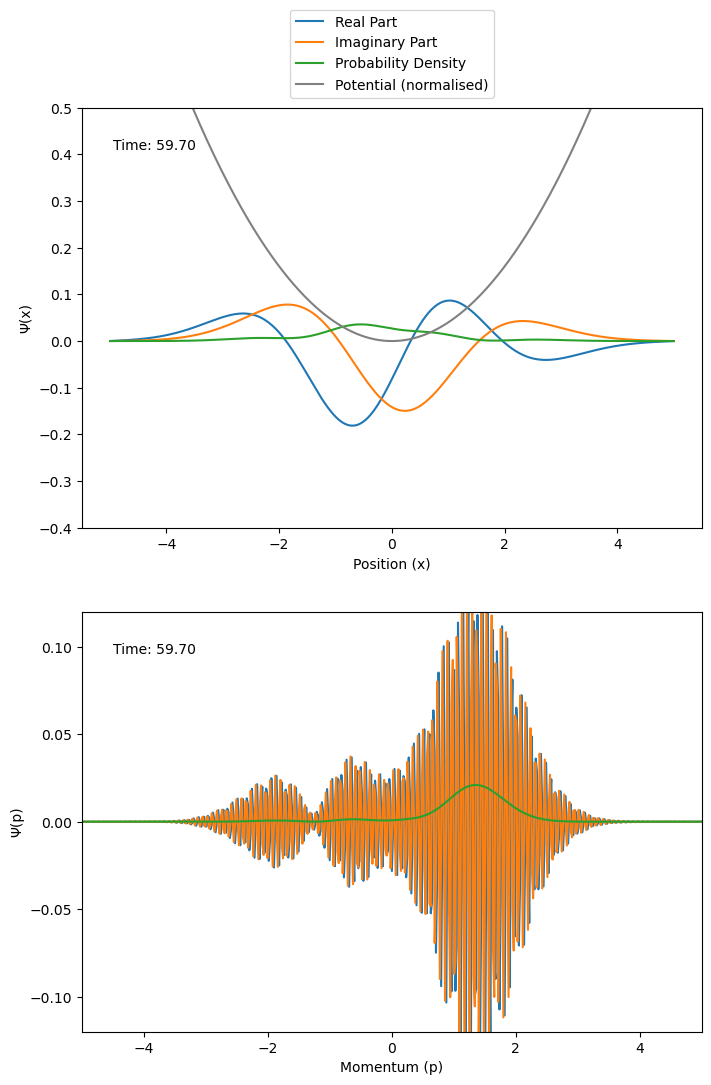

In [102]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from numpy.fft import fft, fftfreq, fftshift

# Constants
ħ = 1.0  # reduced Planck's constant (arbitrary units)

# Quantum harmonic oscillator function with time evolution
def quantum_harmonic_oscillator(m, k, t_max, frames):
    N = 500  # number of points
    x_max = 5.0  # maximum position
    x = np.linspace(-x_max, x_max, N)
    dx = x[1] - x[0]

    # Kinetic and potential energy matrices
    T = -(ħ**2 / (2 * m * dx**2)) * (np.diag(np.ones(N - 1), -1) - 2 * np.diag(np.ones(N), 0) + np.diag(np.ones(N - 1), 1))
    V_eq = 0.5 * k * x**2
    if V_eq.all() != 0:
        V = np.diag(V_eq)
        V_norm = V_eq/max(V_eq)
    else:
        V = 0
    
    # Hamiltonian matrix
    H = T + V

    # Solve for eigenvalues and eigenfunctions
    eigenvalues, eigenfunctions = eigh_tridiagonal(np.diag(H), np.diag(H, 1))

    # Time-dependent function
    def psi_x(x, t):
        wavefunction = np.zeros_like(x, dtype=complex)
        for n in range(4):
            wavefunction += eigenfunctions[:, n] * np.exp(-1j * eigenvalues[n] * t / ħ)
        return wavefunction

    def psi_momentum(psi_x, dx):
        n = 30
        N = len(psi_x)
        N_padded = N * n  # Increase the number of points with zero-padding
    
        # Pad the wavefunction array with zeros
        psi_x_padded = np.pad(psi_x, (N_padded//4, N_padded - N - N_padded//4), mode='constant')
    
        # Normalization factor for the padded wavefunction
        norm_factor = np.sqrt(np.sum(np.abs(psi_x_padded)**2) * dx)
        psi_x_normalized = psi_x_padded / norm_factor
    
        # Compute the Fourier Transform to get the momentum-space wavefunction
        psi_p = fftshift(fft(psi_x_normalized))
        
        # Calculate the corresponding momentum values
        # The momentum axis scaling should match the padded array
        dp = 2 * np.pi / (N_padded * dx)
        p = fftshift(fftfreq(N_padded, d=dx)) * 2 * np.pi * ħ
    
        # Adjust the normalization for the momentum-space wavefunction
        psi_p_normalized = psi_p * np.sqrt(dx / (N_padded * dp)) / (2 * np.pi)
        
        return p, psi_p_normalized



    # Initialize plot for position & momentum
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))

    # Initialize lines for position plot
    ax1.set_ylim(-0.4, 0.5)  # Set y-axis limits
    line_re, = ax1.plot(x, np.real(psi_x(x, 0)), label='Real Part')
    line_im, = ax1.plot(x, np.imag(psi_x(x, 0)), label='Imaginary Part')
    line_abs, = ax1.plot(x, np.abs(psi_x(x, 0))**2, label='Probability Density')
    if V_eq.all() != 0:
        line_potential, = ax1.plot(x, V_norm, label='Potential (normalised)', color='gray')
    time_text1 = ax1.text(0.05, 0.9, '', transform=ax1.transAxes)
    ax1.set_xlabel('Position (x)')
    ax1.set_ylabel('Ψ(x)')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25))

    # Initialize lines for momentum-space plot
    line_p_re, = ax2.plot([], [], label='Real Part (Momentum Space)')
    line_p_im, = ax2.plot([], [], label='Imaginary Part (Momentum Space)')
    line_p_abs, = ax2.plot([], [], label='Probability Density (Momentum Space)')
    time_text2 = ax2.text(0.05, 0.9, '', transform=ax2.transAxes)
    ax2.set_xlabel('Momentum (p)')
    ax2.set_ylabel('Ψ(p)')
    ax2.set_xlim(-5, 5)  # Adjust limits based on expected momentum values
    ax2.set_ylim(-.12, .12)

    # Define the initialization function
    def init():
        psi_x0 = psi_x(x, 0)
        line_re.set_ydata(np.real(psi_x0))
        line_im.set_ydata(np.imag(psi_x0))
        line_abs.set_ydata(np.abs(psi_x0**2))
        time_text1.set_text('')
        time_text2.set_text('')

        # Initialize lines for momentum space
        p0, psi_p0 = psi_momentum(psi_x0, dx)
        line_p_re.set_data(p0, np.real(psi_p0))
        line_p_im.set_data(p0, np.imag(psi_p0))
        line_p_abs.set_data(p0, np.abs(psi_p0)**2)

        return line_re, line_im, line_abs, time_text1, time_text2, line_p_re, line_p_im, line_p_abs

    # Define the update function
    def update(frame):
        t = frame * t_max / frames
        y = psi_x(x, t)
        line_re.set_ydata(np.real(y))
        line_im.set_ydata(np.imag(y))
        line_abs.set_ydata(np.abs(y)**2)
        time_text1.set_text(f'Time: {t:.2f}')
        time_text2.set_text(f'Time: {t:.2f}')

        p, psi_p_t = psi_momentum(y, dx)
        line_p_re.set_data(p, np.real(psi_p_t))
        line_p_im.set_data(p, np.imag(psi_p_t))
        line_p_abs.set_data(p, np.abs(psi_p_t)**2)
        
        return line_re, line_im, line_abs, time_text1, time_text2, line_p_re, line_p_im, line_p_abs

    # Create the animation object
    ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, repeat=True)

    # Convert to HTML5 video
    return ani

# Create and display the animation
ani = quantum_harmonic_oscillator(m=1.0, k=.5, t_max=60, frames=200)
HTML(ani.to_html5_video())